# Vehicle Detection and Tracking

## Global variables and imports

In [13]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label


# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

color_space = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL"
%matplotlib inline

## Feature extraction

### Channel, HOG and Color functions

In [14]:
def bin_spatial(img, size=(32, 32)):
    ch1 = cv2.resize(img[:,:,0], size).ravel() 
    ch2 = cv2.resize(img[:,:,1], size).ravel() 
    ch3 = cv2.resize(img[:,:,2], size).ravel() 
    features = np.concatenate ([ch1, ch2, ch3])
    return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Feature extraction that iterates over training data

In [15]:
def extract_features(imgs, color_space='RGB', 
                     spatial_size=(32, 32),hist_bins=32, 
                     orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, 
                     hog_feat=True):

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor (image, getattr(cv2, 'COLOR_RGB2' + color_space))
        else: 
            feature_image = np.copy(image)      
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Training the classifier

### Reading the training data

In [16]:
def display_image(image, gray=False):
    plt.figure()
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()

def display_grid_images (images, grid_size, cell_size=(10, 10), cmap=None, titles=None):
    sizex, sizey = grid_size[0], grid_size[1]
    fig, imtable = plt.subplots (sizey, sizex, figsize=cell_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx=i+j*sizex
            if (isinstance(cmap,(list, tuple))):
                imtable[j][i].imshow(images[im_idx], cmap=cmap[i])
            else:
                im=images[im_idx]
                if len(im.shape) == 3:
                    imtable[j][i].imshow(im)
                else:
                    imtable[j][i].imshow(im, cmap='gray')
            imtable[j][i].axis('off')
            if not titles is None:
                channels = '' #str(images[im_idx].shape)
                imtable[j][i].set_title(titles[im_idx]+" "+channels, fontsize=20)
                
    plt.show ()
    
    
def read_image_file(path):
    image = mpimg.imread(path)
    read_image = np.copy(image)

    #if 'png' in path:
    #    read_image = image.astype(np.float32) * 255
    return read_image


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [17]:
def list_data_files(path, extension='.png'):
    imgs = []
    for root, dirs, files in os.walk(path):
        for file_ in files:
            if file_.endswith(extension):
                #print( os.path.join(root, file_) )
                imgs.append( os.path.join(root, file_) )
    return imgs

# Read in cars and notcars
cars_dir = './data/vehicles/'
cars_list = list_data_files(cars_dir)
#car_images = [mpimg.imread(file) for file in tqdm(cars_list)]

notcars_dir = './data/non-vehicles/'
notcars_list = list_data_files(notcars_dir)
#notcar_images = [mpimg.imread(file) for file in tqdm(notcars_list)]

print('Number of vehicle files: {}'.format(len(cars_list)))
print('Number of non-vehicle files: {}'.format(len(notcars_list)))

Number of vehicle files: 8792
Number of non-vehicle files: 8968


### Sample data

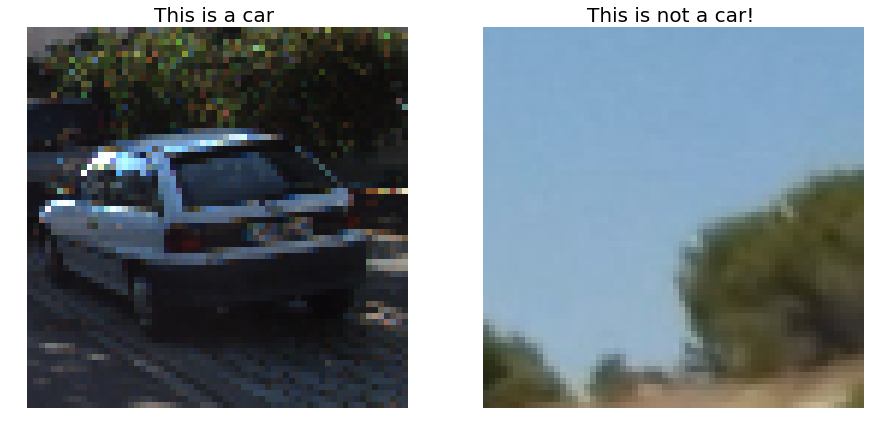

In [6]:
rand_cars_ind = np.random.randint(0, len(cars_list))
rand_notcars_ind = np.random.randint(0, len(notcars_list))

car_sample_img = read_image_file(cars_list[rand_cars_ind])
#car_sample_img = cv2.cvtColor(car_sample_img, cv2.COLOR_BGR2RGB)

not_car_sample_img = read_image_file(notcars_list[rand_notcars_ind])
#not_car_sample_img = cv2.cvtColor(not_car_sample_img, cv2.COLOR_BGR2RGB)

display_grid_images([car_sample_img, not_car_sample_img], (2,1), cell_size=(15, 10), 
                    titles=('This is a car','This is not a car!'))


### Extracting features from training data

In [9]:
#sample_size = 500
#cars = cars_list[0:sample_size]
#notcars = notcars_list[0:sample_size]

car_features = extract_features(cars_list, color_space,spatial_size, hist_bins, orient, pix_per_cell, 
                                 cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

notcar_features  = extract_features(notcars_list, color_space, spatial_size, hist_bins, orient, pix_per_cell, 
                                 cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)



/Users/albertoescarlate/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/Users/albertoescarlate/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)


### Normalize feature vectors

In [12]:
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector
print (len(y))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

17760


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Split up data into randomized training and test sets

In [ ]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Parameters:',orient,'orientations,',pix_per_cell,'pixels per cell,', cell_per_block,
      'cells per block, spatial binning of',spatial_size, 'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

### Linear SVM Classifier

In [ ]:
# Use a linear SVC 
svc = LinearSVC(C=0.1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

##  Sliding Window Search

In [ ]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def single_img_features(img, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat): 
    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
            feature_image = cv2.cvtColor (img, getattr(cv2, 'COLOR_RGB2' + color_space))
    else: 
        feature_image = np.copy(img)  
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)

# Function that passes an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space, 
                    spatial_size, hist_bins, orient, 
                    pix_per_cell, cell_per_block, 
                    hog_channel, spatial_feat, 
                    hist_feat, hog_feat):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space, 
                            spatial_size, hist_bins,orient, pix_per_cell,cell_per_block, 
                            hog_channel, spatial_feat, hist_feat, hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def draw_boxes(img, bboxes, color, thick):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


### Tiling Schemes

In [ ]:
#Using three different schemes for the same image
image = mpimg.imread('./test_images/test3.jpg')
window_img = np.copy(image)

sw_x_limits = [[None, None],[32, None],[400, 1280]]
sw_y_limits = [[400, 640],[400, 600],[390, 540]]
sw_window_size = [(128, 128),(96, 96),(64, 64)]
sw_overlap = [(0.5, 0.5),(0.5, 0.5),(0.5, 0.5)]

display_imgs = []

for i in range(3):
    windows = slide_window(window_img, sw_x_limits[i], sw_y_limits[i], sw_window_size[i], sw_overlap[i])  
    bboxes = search_windows(window_img, windows, svc, X_scaler, color_space,
                            spatial_size, hist_bins, orient, 
                            pix_per_cell, cell_per_block, 
                            hog_channel, spatial_feat, 
                            hist_feat, hog_feat)  
    
    

 
    display_img = draw_boxes(window_img, bboxes, color=(0, 255, 255), thick=3)
    display_imgs.append(display_img)
    
    
display_grid_images(display_imgs, (3, 1), cell_size=(20, 10), titles=('128x128','96x96', '80x80'))


### Optimizing search windows

In [ ]:
# Function that  extracts features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, display_boxes):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    boxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

                if display_boxes:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                                      
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                
                         
    return draw_img, boxes


In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold    
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img      

### Debugging some troublesome frames

In [ ]:
images = glob.glob('./test_images/*.jpg')
images = ['./frames/in1045.jpg', './frames/in1043.jpg', 
          './frames/in1042.jpg', './frames/in1044.jpg']
          
ystart = 400
ystop = 656
scale = 1.2

display_images = []
title = []
labeled_box_imgs = []

for idx, fname in enumerate(images):
    source_img = read_image_file(str(fname))
    out_img, boxes = find_cars(source_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, True)
      
    heat_map = np.zeros_like(source_img[:,:,0]).astype(np.float)
    heat_map = add_heat(heat_map, boxes)
    heat_map = apply_threshold(heat_map, 1)
    heatmap = np.clip(heat_map, 0, 255)
      
    labels = label(heatmap)  
    labeled_box_img = draw_labeled_bboxes(source_img, labels)

    display_images.append(out_img)
    display_images.append(heatmap)
    display_images.append(labeled_box_img)
    title.append(fname)
    title.append('heatmap')
    title.append('bounding box')
    
display_grid_images(display_images, (3, int(len(display_images)/3)), cell_size=(20, 20), titles=title)



In [ ]:
import collections
heatmaps = collections.deque(maxlen=10) 
    
def process_frame(source_img):

    out_img, boxes = find_cars(source_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, False)

    current_heatmap = np.zeros_like(source_img[:,:,0]).astype(np.float)
    current_heatmap = add_heat(current_heatmap, boxes)
    heatmaps.append(current_heatmap)
    heatmap_sum = sum(heatmaps)
  
    heat_map = apply_threshold(heatmap_sum, 2)
    heatmap = np.clip(heat_map, 0, 255)
    labels = label(heatmap)  
    labeled_box_img = draw_labeled_bboxes(source_img, labels)

    #save_frame(labeled_box_img)

    return labeled_box_img


def save_frame(source_img):
# Auxiliary function to save frames in the video pipeline
    global iidx
    iidx += 1
    write_name = './frames/out'+str(iidx)+'.jpg'
    img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(write_name, img)


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
global iidx
iidx = 0

clip = VideoFileClip('project_video.mp4')
out_clip = clip.fl_image(process_frame) 
%time out_clip.write_videofile('output_video.mp4', audio=False)

In [ ]:
HTML("""
<video width="1280" height="760" controls>
  <source src="{0}">
</video>
""".format('output_video.mp4'))